In [10]:
# Remove all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category = DeprecationWarning)

In [11]:

import torch 
import torchvision
import matplotlib.pyplot as plt
import tensorflow
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# import datasets
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.datasets import fashion_mnist

# Set cuda launch blocking = '1'
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina Display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
torch.cuda.set_device(1)

In [13]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

#printing the shapes of the vectors 
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


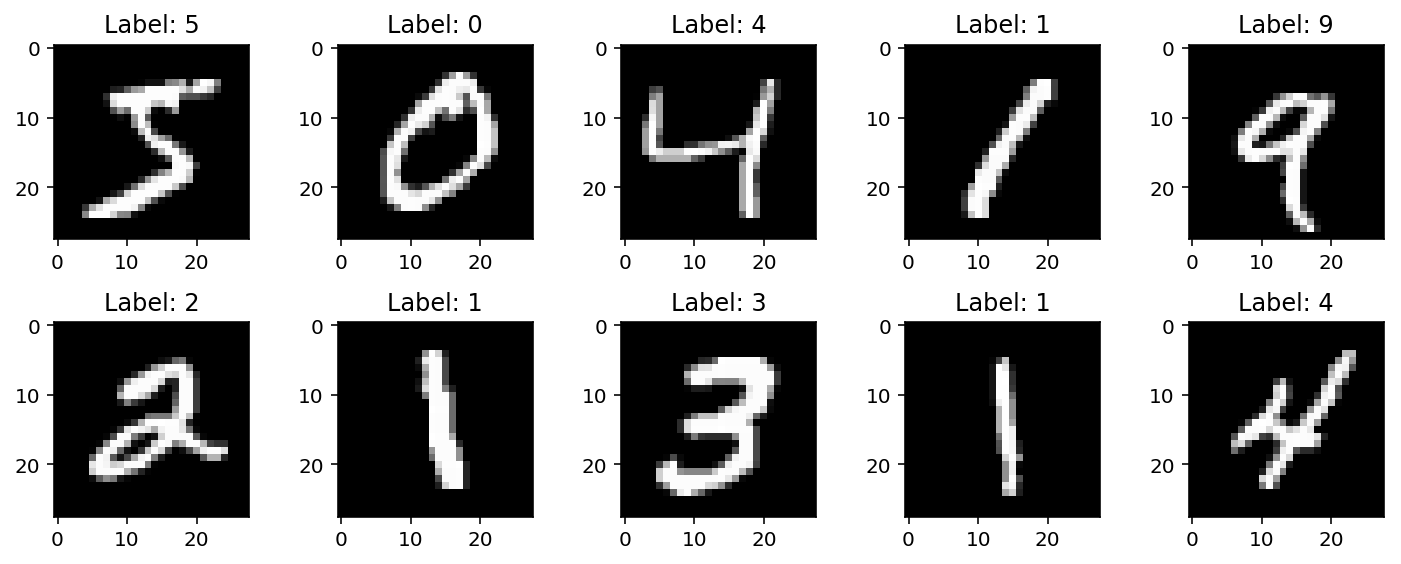

In [14]:
num = 10
images = train_X[:num]
labels = train_y[:num]
num_row = 2
num_col = 5

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

### <i>Visualizing MNIST dataset using t-SNE</i>

In [15]:
samples,height,width = train_X.shape

# Flatten 28 x 28 image --> 784 : (60000, 28, 28) --> (60000, 784)
flatten_train_x = train_X.flatten().reshape(samples,height*width).astype(np.float)

print('X-train:',flatten_train_x.shape)
print('Y-train:',train_y.shape)

X-train: (60000, 784)
Y-train: (60000,)


In [7]:
tsne = TSNE(n_components=2 , perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(flatten_train_x)

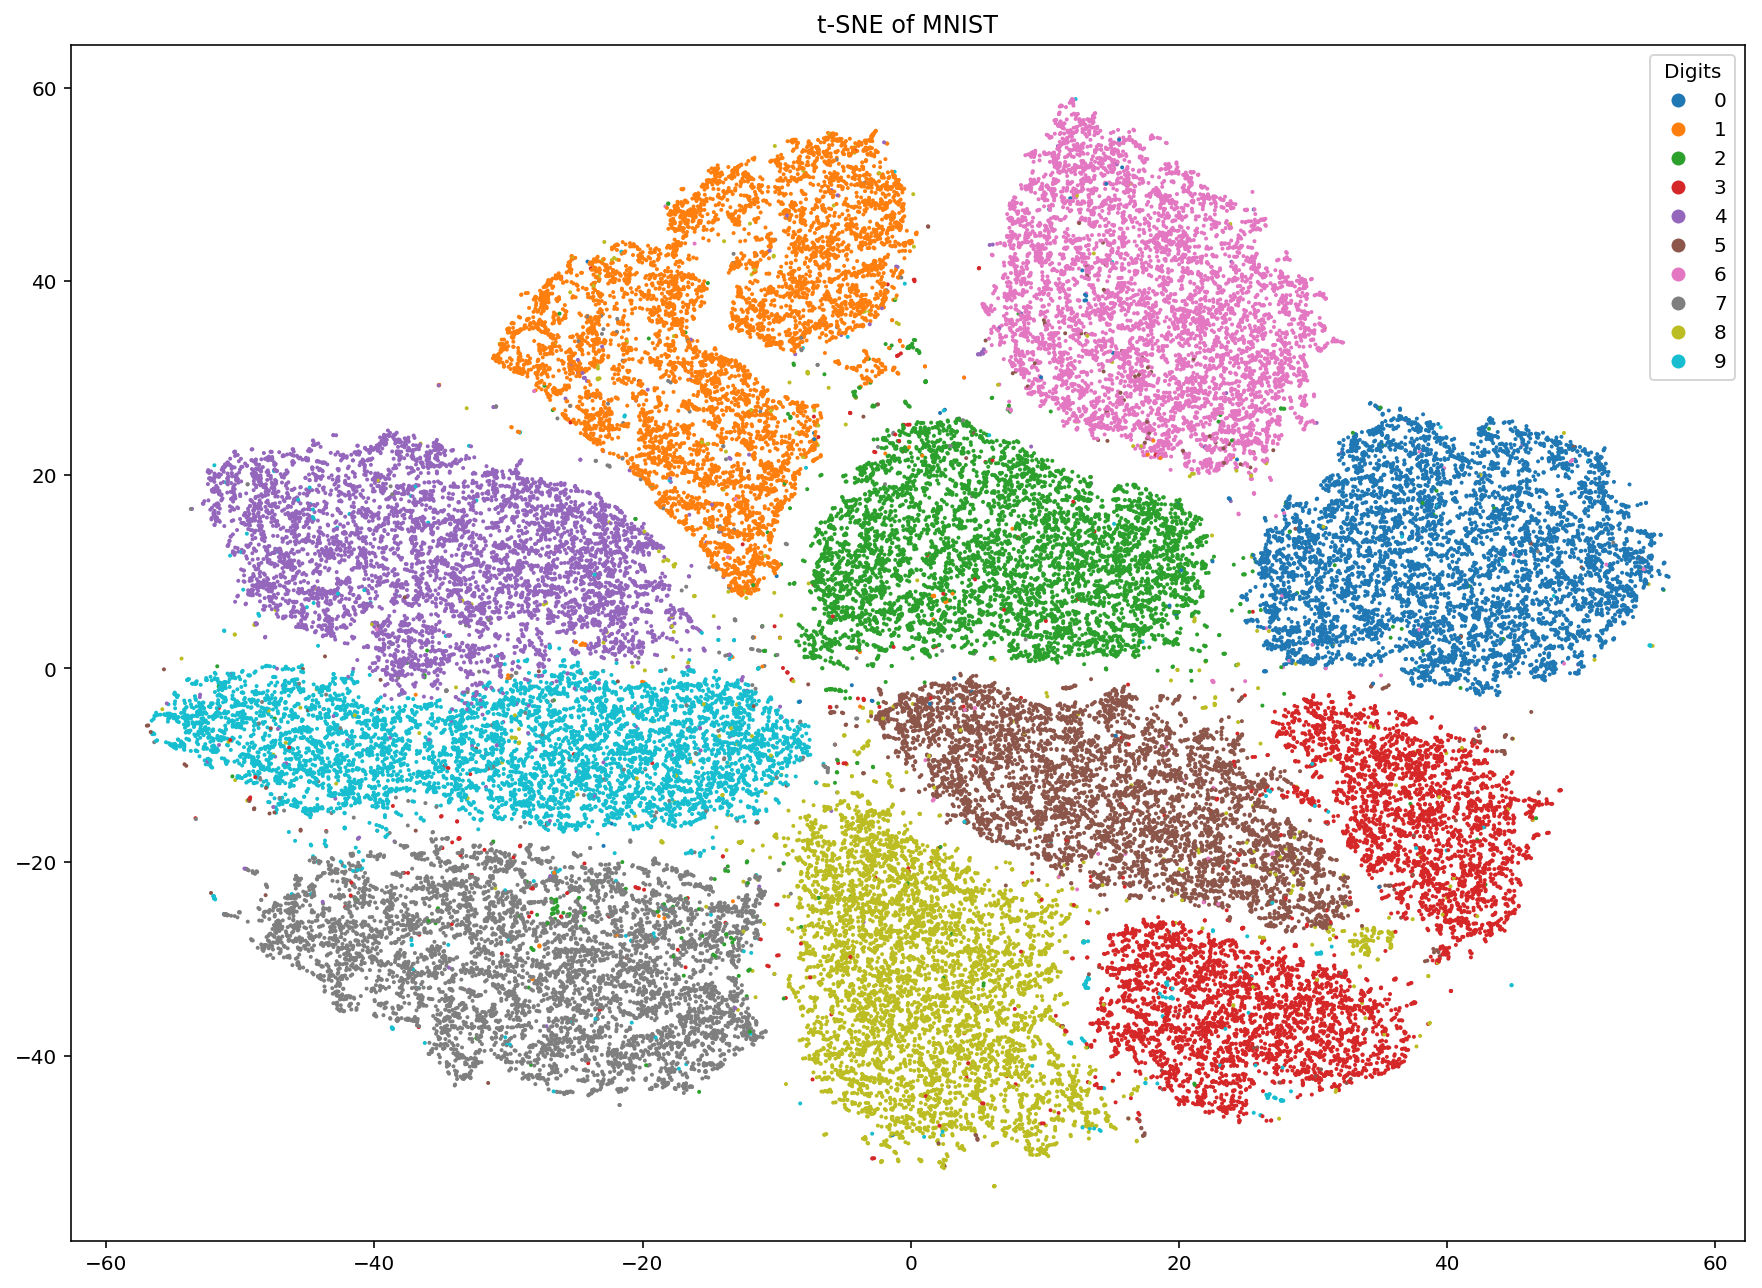

In [10]:
# Plot the result
plt.figure(figsize=(15, 11))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_y.astype(int), cmap='tab10', s=1)
# plt.legend(*scatter.legend_elements(), title="Digits")
plt.title('t-SNE of MNIST')
classes = list(range(10))  # Since MNIST has digits 0-9
colors = [scatter.cmap(scatter.norm(value)) for value in classes]
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8) for color in colors],
           labels=classes, title="Digits")

plt.show()

In [16]:
test_samples = test_X.shape[0]
test_X = test_X.reshape(test_samples,-1)

In [17]:
# Normailizing the dataset.
scaler_img  = MinMaxScaler().fit(flatten_train_x.reshape(-1,1))
flatten_train_x = scaler_img.transform(flatten_train_x.reshape(-1,1)).reshape(flatten_train_x.shape)
flatten_test_x = scaler_img.transform(test_X.reshape(-1,1)).reshape(test_X.shape)

print("X-train: ",flatten_train_x.shape)
print("X-test:",flatten_test_x.shape)

X-train:  (60000, 784)
X-test: (10000, 784)


In [18]:
flatten_train_x = torch.tensor(flatten_train_x, dtype= torch.float32).to(device)
flatten_test_x = torch.tensor(flatten_test_x, dtype = torch.float32).to(device)
train_y = torch.tensor(train_y, dtype= torch.uint8).to(device)

### <i>Using Muliti-Layer Perceptrons</i>

In [19]:
class MLP(nn.Module):
    def __init__(self, features, hidden1, hidden2, labels):
        super(MLP, self).__init__()
        self.lin1 = nn.Linear(features, hidden1)
        self.lin2 = nn.Linear(hidden1, hidden2)
        self.lin3 = nn.Linear(hidden2, labels) 

    def forward(self, x, get_hidden_output = False):
        x = torch.relu(self.lin1(x))
        x= torch.relu(self.lin2(x))
        if get_hidden_output:
            return x
        x = self.lin3(x)
        return x

In [20]:
features = flatten_train_x.shape[1]
hidden1 = 30
hidden2 = 20
labels = 10

model = MLP(features, hidden1, hidden2, labels).to(device)

In [21]:
untrain_hidden_logits = model(flatten_test_x, get_hidden_output = True)

In [22]:
untrain_hidden_logits.shape

torch.Size([10000, 20])

In [23]:
untrain_hidden_y_pred = torch.argmax(F.softmax(untrain_hidden_logits, dim = -1), dim = -1).cpu().numpy()

In [24]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr = 0.05)

epochs = 10000
print_every = 1000

mlp_loss = []
for epoch in range(epochs):
    
    y_pred = model(flatten_train_x)
    # y_pred = y_pred.argmax(axis = -1)

    loss = loss_fn(y_pred, train_y.long())
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    mlp_loss.append(loss.item())
    if epoch % print_every == 0 or epoch == epochs-1:
        print("Epoch:",epoch,"loss:",loss.item())
        

Epoch: 0 loss: 2.3120617866516113
Epoch: 1000 loss: 0.04599159210920334
Epoch: 2000 loss: 0.021092798560857773
Epoch: 3000 loss: 0.1009749099612236
Epoch: 4000 loss: 0.07348571717739105
Epoch: 5000 loss: 0.05484841391444206
Epoch: 6000 loss: 0.19030772149562836
Epoch: 7000 loss: 0.03931538015604019
Epoch: 8000 loss: 0.03521505370736122
Epoch: 9000 loss: 0.04854452982544899
Epoch: 9999 loss: 0.025300778448581696


In [25]:
from sklearn.metrics import f1_score, confusion_matrix

In [26]:
logits = model(flatten_test_x)

In [27]:
y_pred = torch.argmax(F.softmax(logits, dim = -1), dim = -1).cpu().numpy()

In [28]:
mlp_f1_score = f1_score(test_y, y_pred, average = 'macro')
print("MLP F1-Score:", mlp_f1_score)

MLP F1-Score: 0.9190181834428721


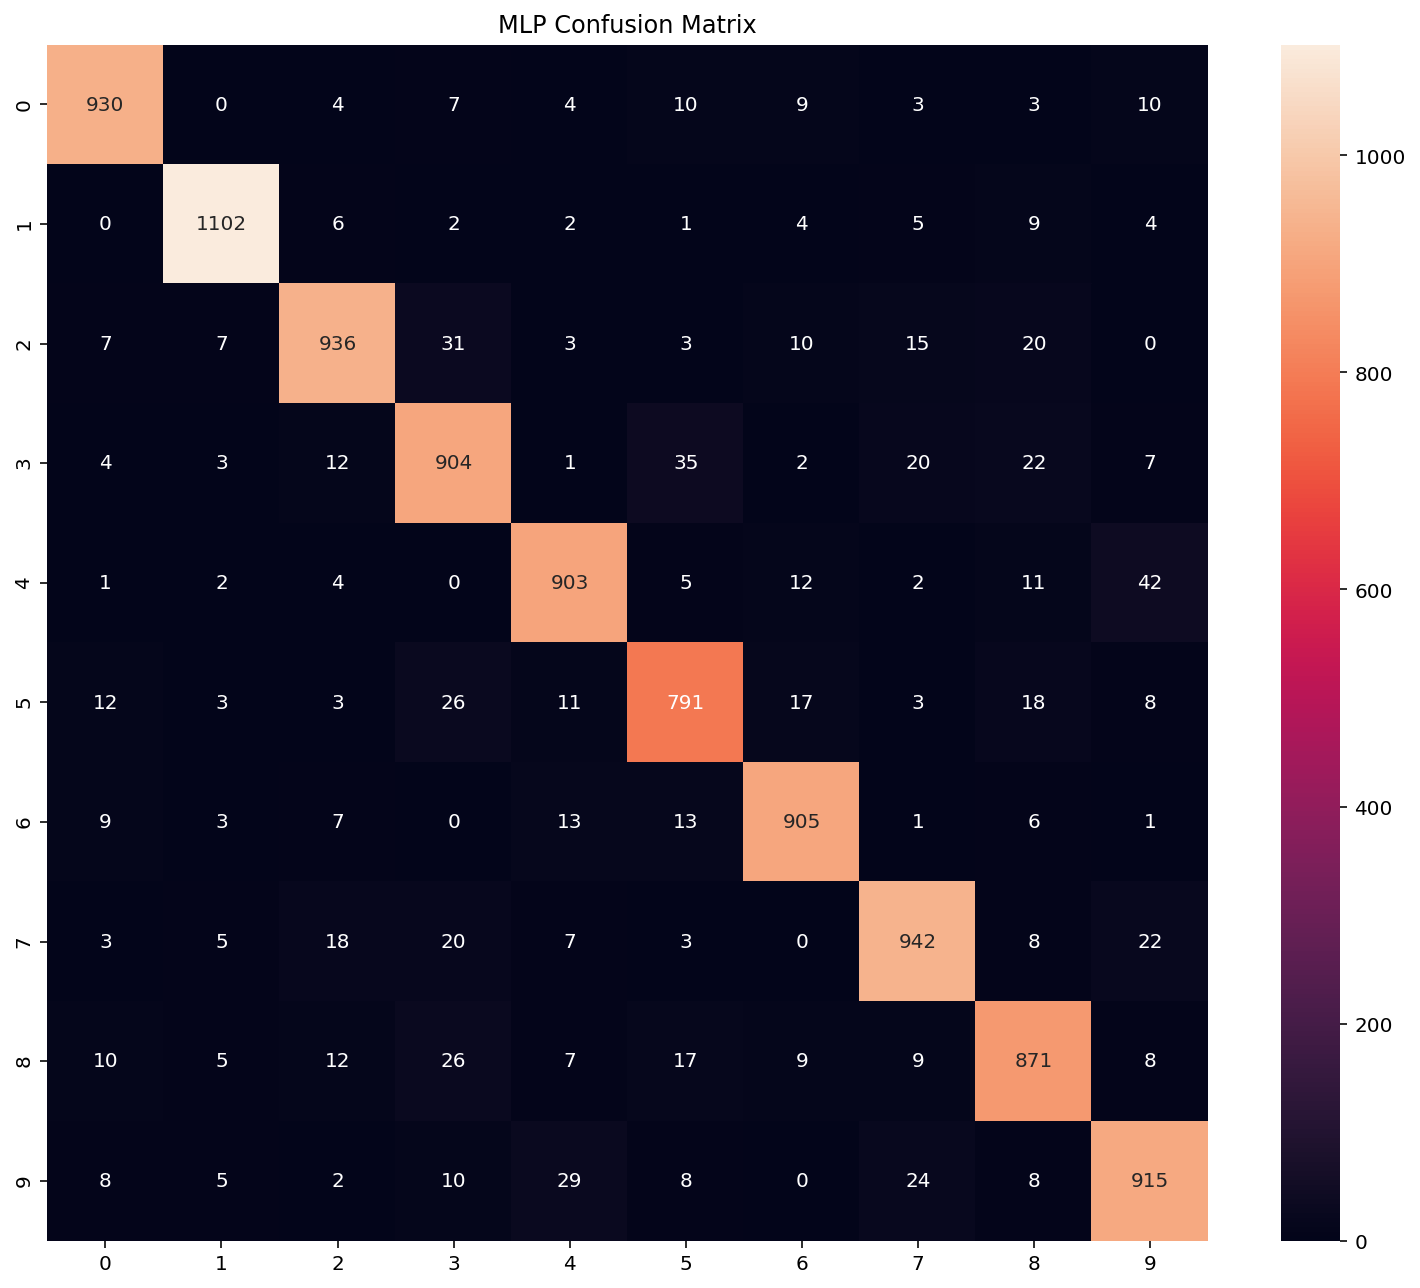

In [29]:
from seaborn import heatmap

mlp_confusion = confusion_matrix(test_y, y_pred, labels = [0,1,2,3,4,5,6,7,8,9])

plt.figure(figsize=(13,11))
heatmap(mlp_confusion, annot = True, fmt = 'g')
plt.title("MLP Confusion Matrix")
plt.show()

#### <i>Prediction from Hidden Layer</i>

In [30]:
# Hidden Output for Untrained Model
hidden_tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
untrain_hidden_logits_tsne  = hidden_tsne.fit_transform(untrain_hidden_logits.cpu().detach().numpy())

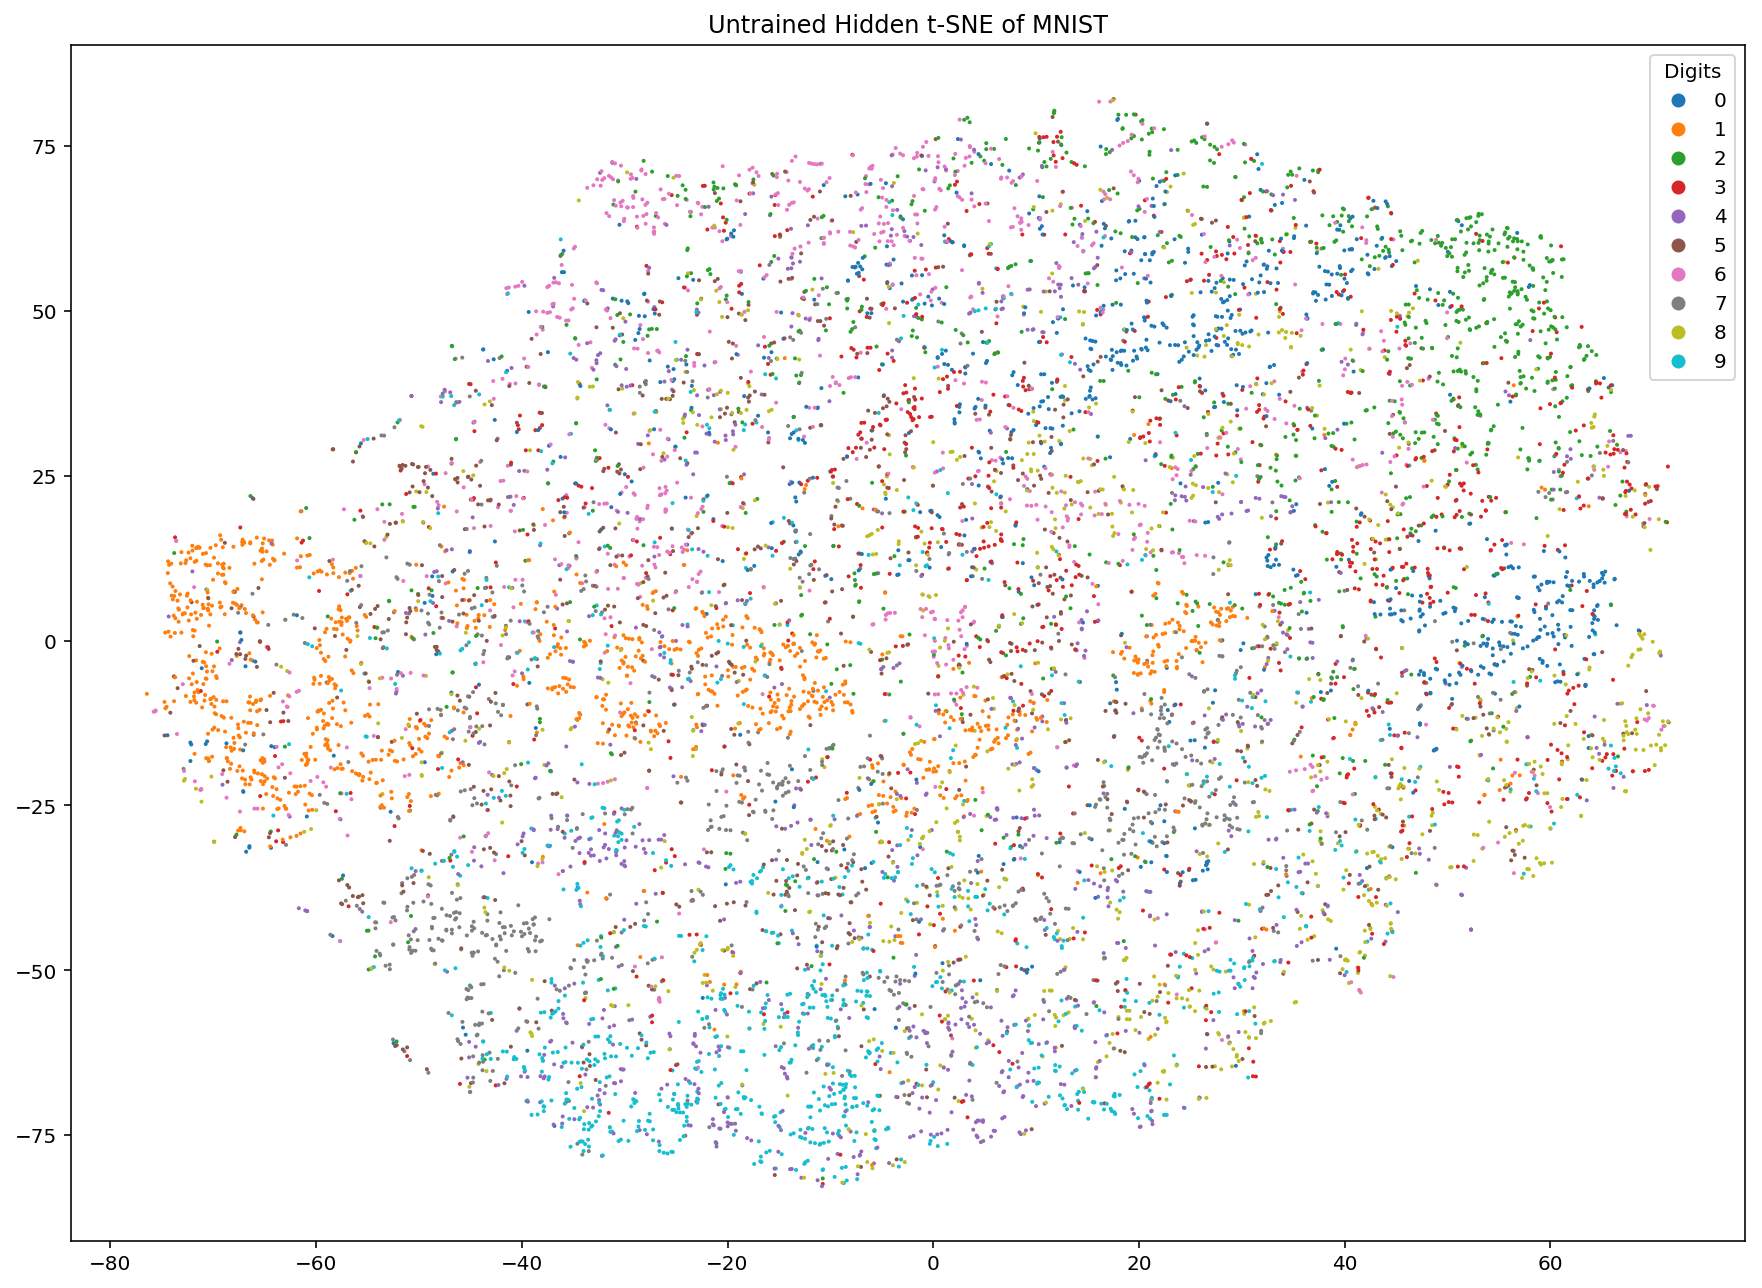

In [31]:
plt.figure(figsize=(15, 11))
scatter = plt.scatter(untrain_hidden_logits_tsne[:, 0], untrain_hidden_logits_tsne[:, 1], c=test_y.astype(int), cmap='tab10', s=1)

plt.title('Untrained Hidden t-SNE of MNIST')

classes = list(range(10))  # Since MNIST has digits 0-9
colors = [scatter.cmap(scatter.norm(value)) for value in classes]
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8) for color in colors],
           labels=classes, title="Digits")

plt.show()

In [32]:
train_hidden_logits = model(flatten_test_x, get_hidden_output = True)

In [33]:
train_hidden_logits_tsne = hidden_tsne.fit_transform(train_hidden_logits.cpu().detach().numpy())

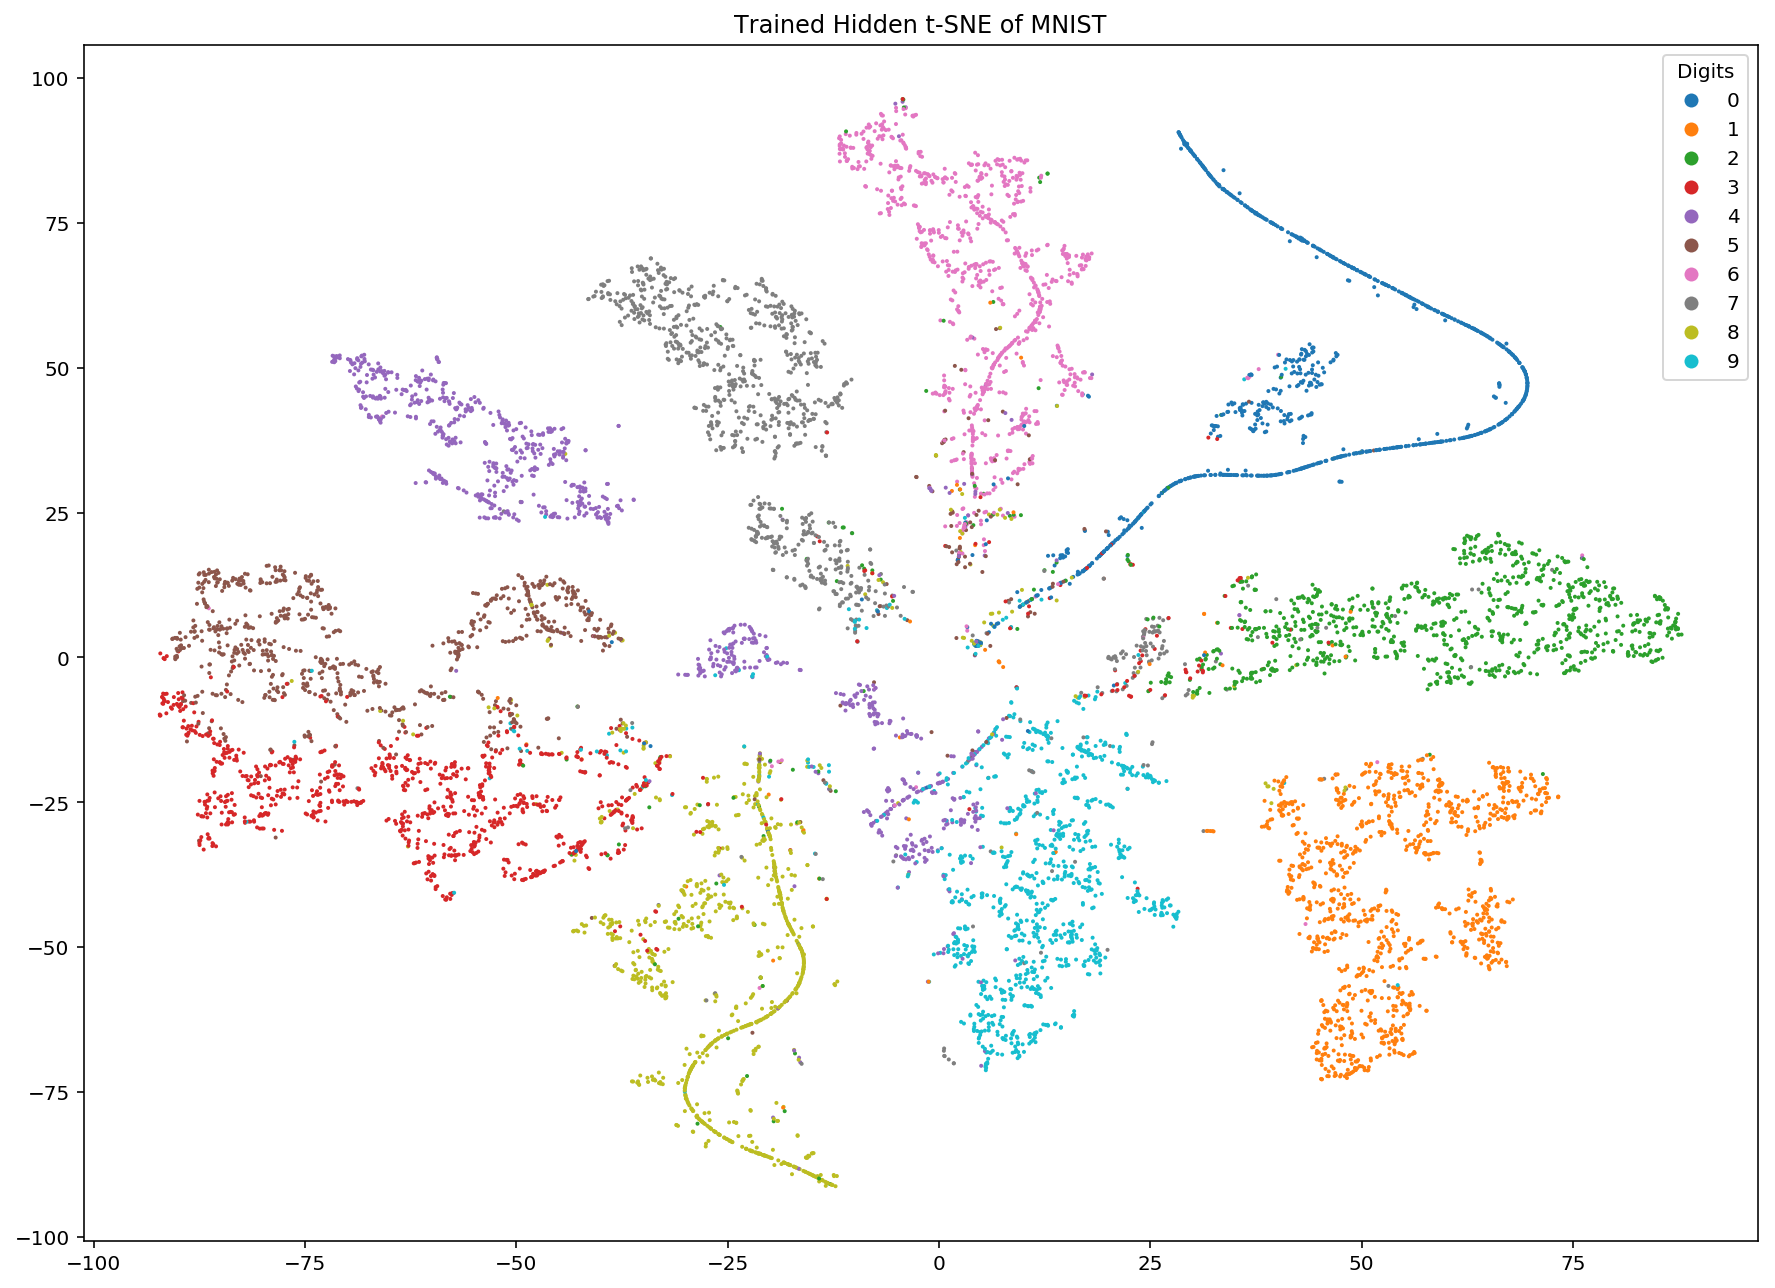

In [34]:
plt.figure(figsize=(15, 11))
scatter = plt.scatter(train_hidden_logits_tsne[:, 0], train_hidden_logits_tsne[:, 1], c=test_y.astype(int), cmap='tab10', s=1)
plt.title('Trained Hidden t-SNE of MNIST')
classes = list(range(10))  # Since MNIST has digits 0-9
colors = [scatter.cmap(scatter.norm(value)) for value in classes]
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8) for color in colors],
           labels=classes, title="Digits")

plt.show()

#### <i>Fashion Mnist</i>

In [35]:
(fm_train_X, fm_train_y),(fm_test_X, fm_test_y) = fashion_mnist.load_data()

#printing the shapes of the vectors 
print('X_train: ' + str(fm_train_X.shape))
print('Y_train: ' + str(fm_train_y.shape))
print('X_test:  '  + str(fm_test_X.shape))
print('Y_test:  '  + str(fm_test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


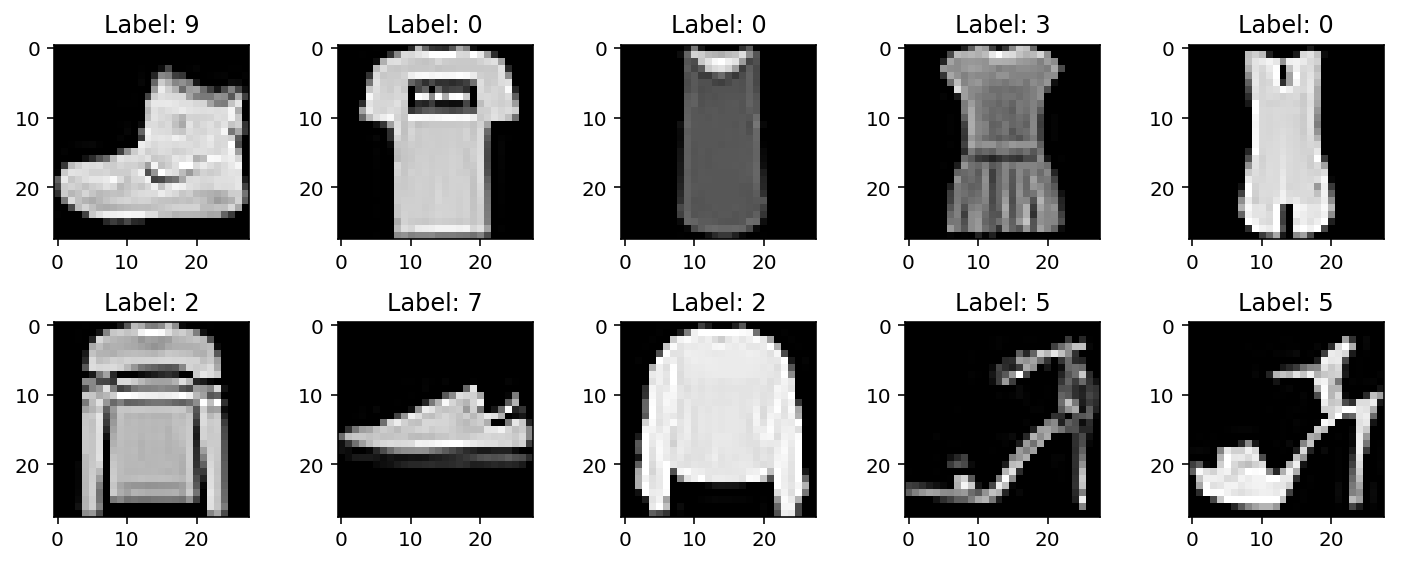

In [36]:
num = 10
images = fm_train_X[:num]
labels = fm_train_y[:num]
num_row = 2
num_col = 5

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [37]:
# Flattening the images 
samples,height,width = fm_train_X.shape

# Flatten 28 x 28 image --> 784 : (60000, 28, 28) --> (60000, 784)
flatten_fm_train_x = fm_train_X.flatten().reshape(samples,height*width).astype(np.float)

test_samples = fm_test_X.shape[0]
flatten_fm_test_x = test_X.reshape(test_samples,-1)

print('X-train:',flatten_fm_train_x.shape)
print('Y-train:',fm_train_y.shape)
print('X_test:  ',flatten_fm_test_x.shape)
print('Y_test:  ',fm_test_y.shape)

X-train: (60000, 784)
Y-train: (60000,)
X_test:   (10000, 784)
Y_test:   (10000,)


In [38]:
# Normailizing the dataset.
scaler_img  = MinMaxScaler().fit(flatten_fm_train_x.reshape(-1,1))
flatten_fm_train_x = scaler_img.transform(flatten_fm_train_x.reshape(-1,1)).reshape(flatten_fm_train_x.shape)
flatten_fm_test_x = scaler_img.transform(flatten_fm_test_x.reshape(-1,1)).reshape(flatten_fm_test_x.shape)

print("X-train: ",flatten_fm_train_x.shape)
print("X-test:",flatten_fm_test_x.shape)

X-train:  (60000, 784)
X-test: (10000, 784)


In [39]:
flatten_fm_train_x = torch.tensor(flatten_fm_train_x, dtype= torch.float32).to(device)
flatten_fm_test_x = torch.tensor(flatten_fm_test_x, dtype = torch.float32).to(device)
fm_train_y = torch.tensor(fm_train_y, dtype= torch.uint8).to(device)

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
fm_logits = model(flatten_fm_test_x)
fm_y_pred = torch.argmax(F.softmax(fm_logits, dim = -1), dim = -1).cpu().numpy()

In [41]:
fm_f1_score = f1_score(fm_test_y, fm_y_pred, average = 'macro')
print("Fashion Mnist F1-Score:", fm_f1_score)

Fashion Mnist F1-Score: 0.0962014139984259


In [42]:
fashion_mnist_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt','Sneaker', 'Bag', 'Ankle boot']

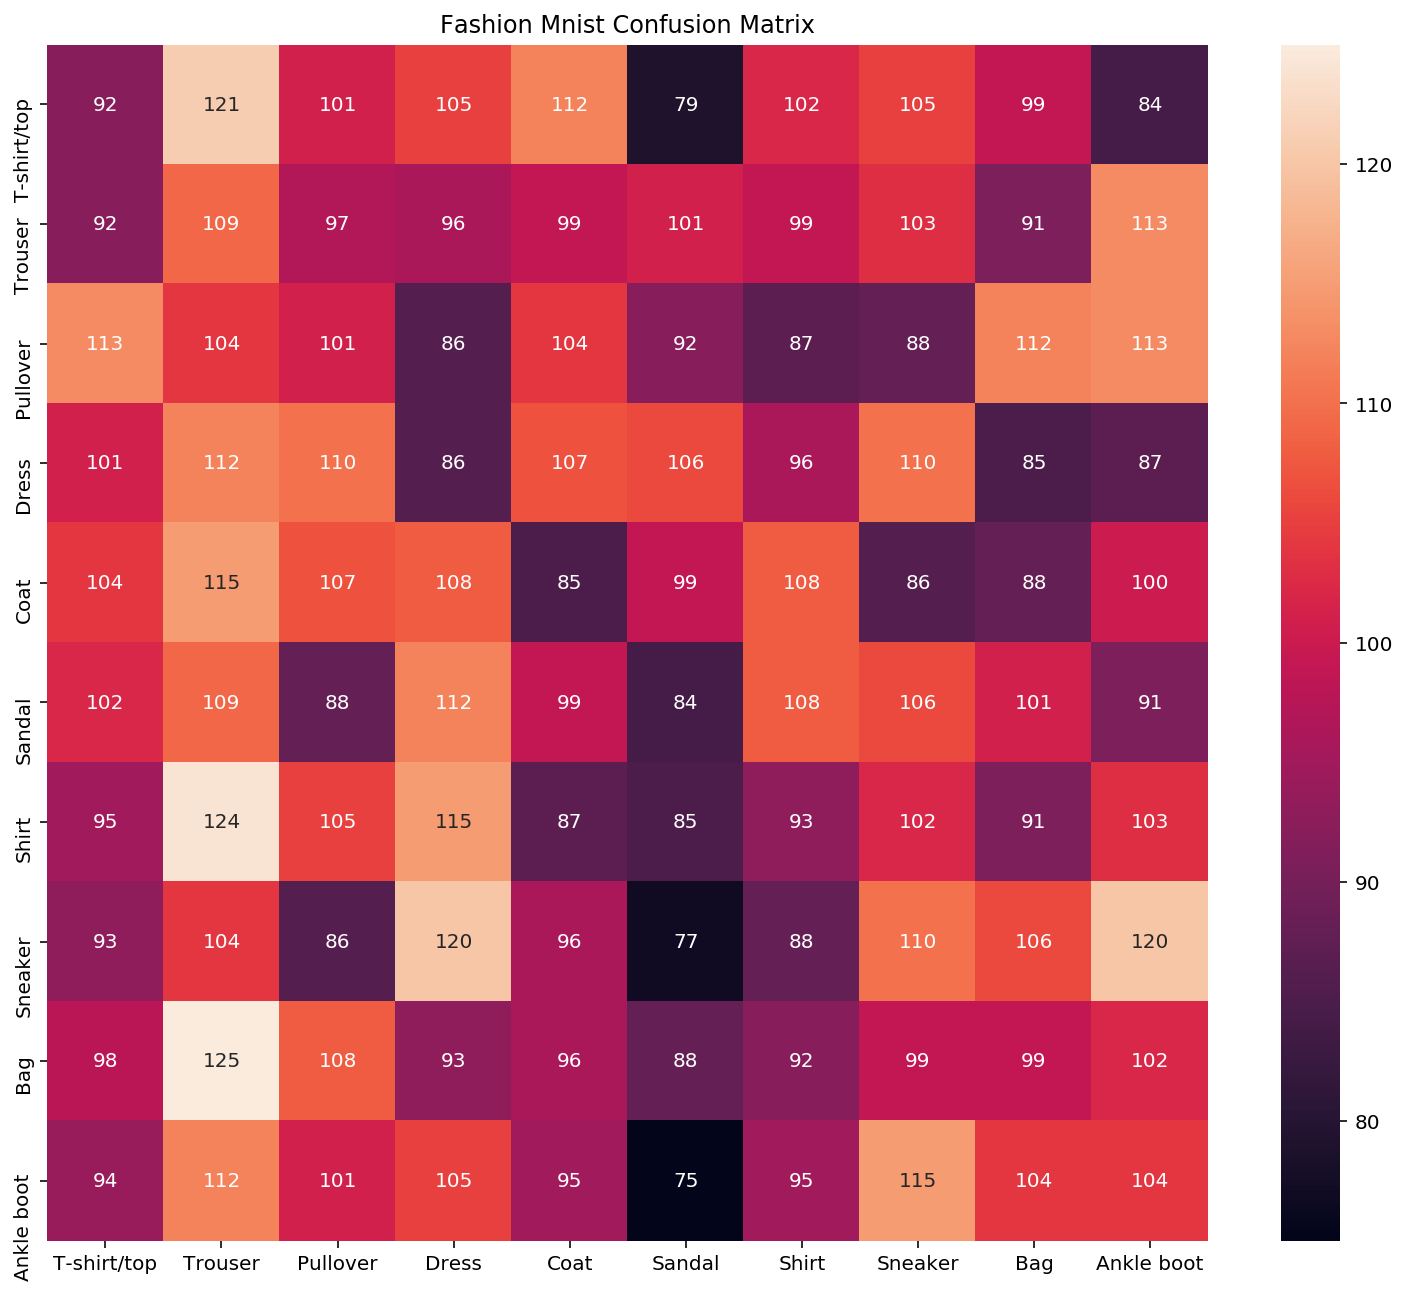

In [43]:
fm_confusion = confusion_matrix(fm_test_y, fm_y_pred, labels = [0,1,2,3,4,5,6,7,8,9])

plt.figure(figsize=(13,11))
heatmap(fm_confusion, annot = True, fmt = 'g')
plt.xticks(np.arange(10) + 0.5, fashion_mnist_labels)
plt.yticks(np.arange(10) + 0.5, fashion_mnist_labels)
plt.title("Fashion Mnist Confusion Matrix")
plt.show()

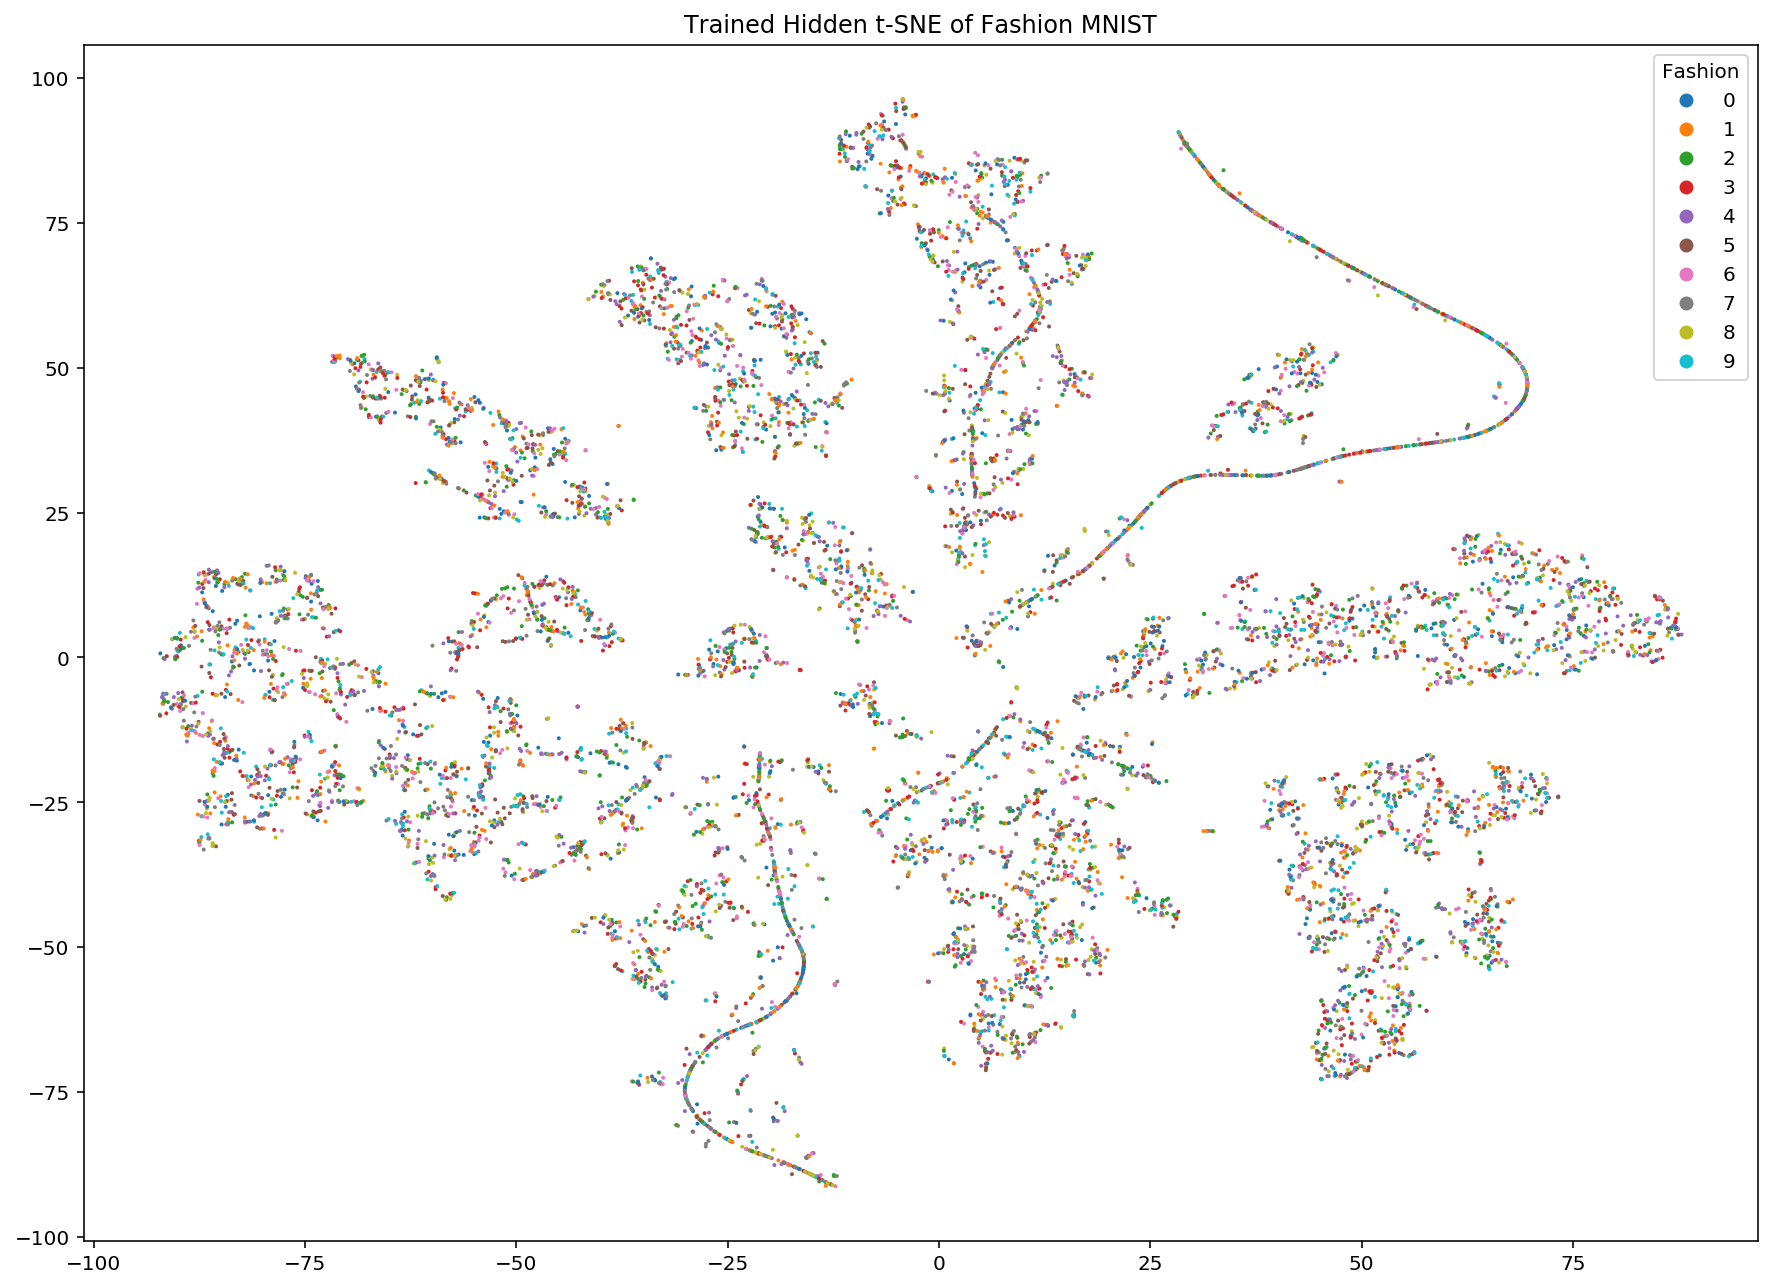

In [44]:
# Visualizing the Hidden Outputs of Fashion Mnist
fm_train_hidden_logits = model(flatten_fm_test_x, get_hidden_output = True)

fm_train_hidden_logits_tsne = hidden_tsne.fit_transform(fm_train_hidden_logits.cpu().detach().numpy())

plt.figure(figsize=(15, 11))
scatter = plt.scatter(fm_train_hidden_logits_tsne[:, 0], fm_train_hidden_logits_tsne[:, 1], c=fm_test_y.astype(int), cmap='tab10', s=1)
plt.title('Trained Hidden t-SNE of Fashion MNIST')
classes = list(range(10))  # Since MNIST has digits 0-9
colors = [scatter.cmap(scatter.norm(value)) for value in classes]
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8) for color in colors],
           labels=classes, title="Fashion")

plt.show()

#### <i>Now, use the trained MLP to predict on the Fashion-MNIST dataset. What do you observe</i>

<i>Lack of Relevant Features: The hidden layers in the MLP trained on MNIST are specialized in recognizing the unique structure and patterns of digits. For example, edges and curves specific to digits don’t generalize well to clothing shapes like T-shirts, trousers, and shoes. Thus, the MLP lacks relevant features for Fashion-MNIST, leading to poor predictions.</i>

<i>Low Accuracy and Misclassifications: You’ll likely observe low accuracy and a high confusion rate between classes in Fashion-MNIST. For instance, items that share certain shapes, such as T-shirts and pullovers, might be misclassified due to lack of relevant feature learning.</i>

<i>t-SNE Embedding Observations: If you visualize the activations of a hidden layer using t-SNE, you’ll likely observe that Fashion-MNIST data points don't form distinct clusters as they did with MNIST. The learned embeddings from MNIST do not effectively separate the Fashion-MNIST classes, indicating that the features learned on MNIST don’t map well onto Fashion-MNIST.</i>

### <i>Logistic Regression</i>

In [30]:
class LogisticRegression(nn.Module):
    def __init__(self,features, labels):
        super().__init__()
        self.lin = nn.Linear(features, labels)
    
    def forward(self,x):
        return torch.relu(self.lin(x))

In [107]:
# training the Logistic Regression Model
features = flatten_train_x.shape[1]
labels = 10

logistic_model = LogisticRegression(features, labels).to(device)

loss_fn = nn.CrossEntropyLoss()

optim = torch.optim.Adam(logistic_model.parameters(), lr = 0.01)

epochs = 10000
print_every = 1000

logistic_loss = []
for epoch in range(epochs):
    logits = logistic_model(flatten_train_x)

    loss = loss_fn(logits, train_y.long())
    loss.backward()
    optim.step()
    optim.zero_grad()
    logistic_loss.append(loss.item())
    if epoch % print_every == 0 or epoch == epochs-1:
        print("epcohs:",epoch,"loss:",loss.item())

epcohs: 0 loss: 2.3203437328338623
epcohs: 1000 loss: 0.44183915853500366
epcohs: 2000 loss: 0.42803364992141724
epcohs: 3000 loss: 0.4216870665550232
epcohs: 4000 loss: 0.4181462824344635
epcohs: 5000 loss: 0.41585785150527954
epcohs: 6000 loss: 0.4141975939273834
epcohs: 7000 loss: 0.4131886661052704
epcohs: 8000 loss: 0.41269707679748535
epcohs: 9000 loss: 0.41235867142677307
epcohs: 9999 loss: 0.4122318625450134


In [42]:
# Predicting on test data logistic regression model
logistic_logits = logistic_model(flatten_test_x)
logistic_y_pred = torch.argmax(F.softmax(logistic_logits, dim = -1), dim = -1).cpu().numpy()

In [70]:
# F1 Score of logistic regression model
logistic_f1_score = f1_score(test_y, logistic_y_pred, average = 'macro')
print("Logistic Regression F1-Score:",logistic_f1_score)

Logistic Regression F1-Score: 0.5813928174542591


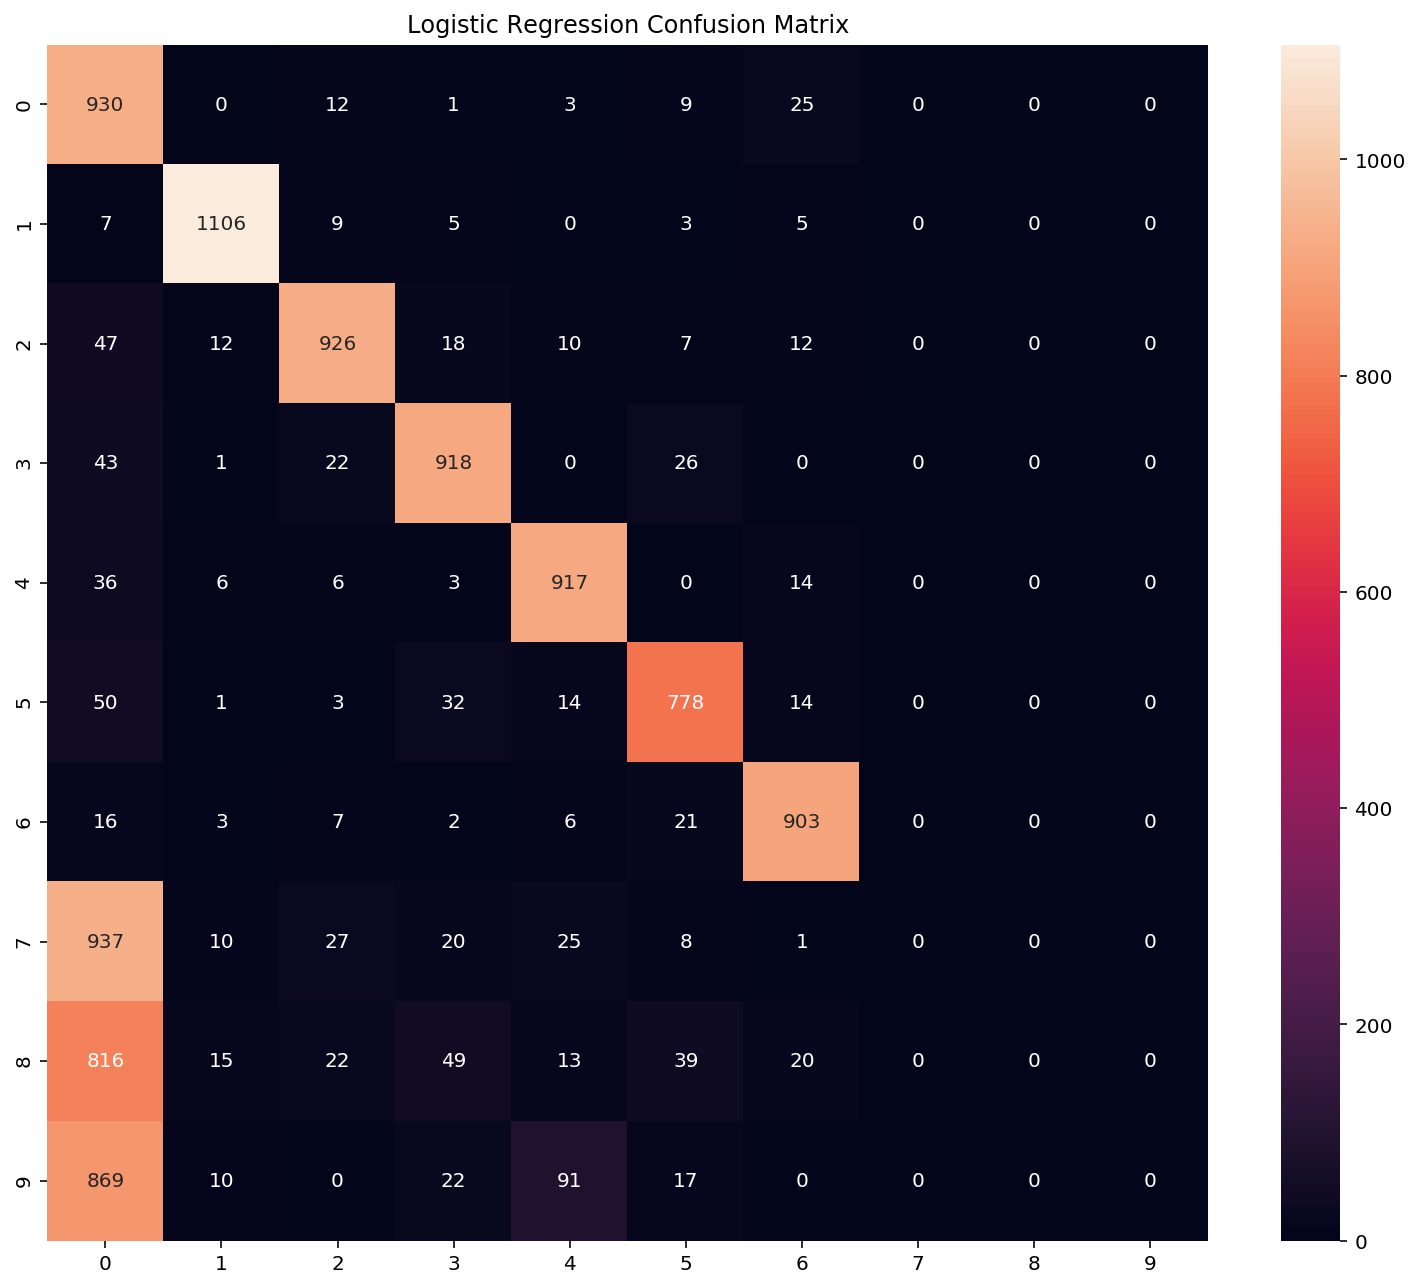

In [66]:
# Confusion Matrix 
logistic_confusion = confusion_matrix(test_y, logistic_y_pred, labels= [0,1,2,3,4,5,6,7,8,9])

plt.figure(figsize = (13, 11))
heatmap(logistic_confusion, annot =True, fmt= 'g')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

### <i>Using Random Forests</i>

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
rf = RandomForestClassifier(n_estimators= 100, random_state = 42)
rf.fit(flatten_train_x.cpu(), train_y.cpu())
rf_y_pred = rf.predict(flatten_test_x.cpu())

In [80]:
rf_f1_score = f1_score(test_y, rf_y_pred, average = 'macro')
print("Random Forests F1-Score:", rf_f1_score)

Random Forests F1-Score: 0.9701627566191542


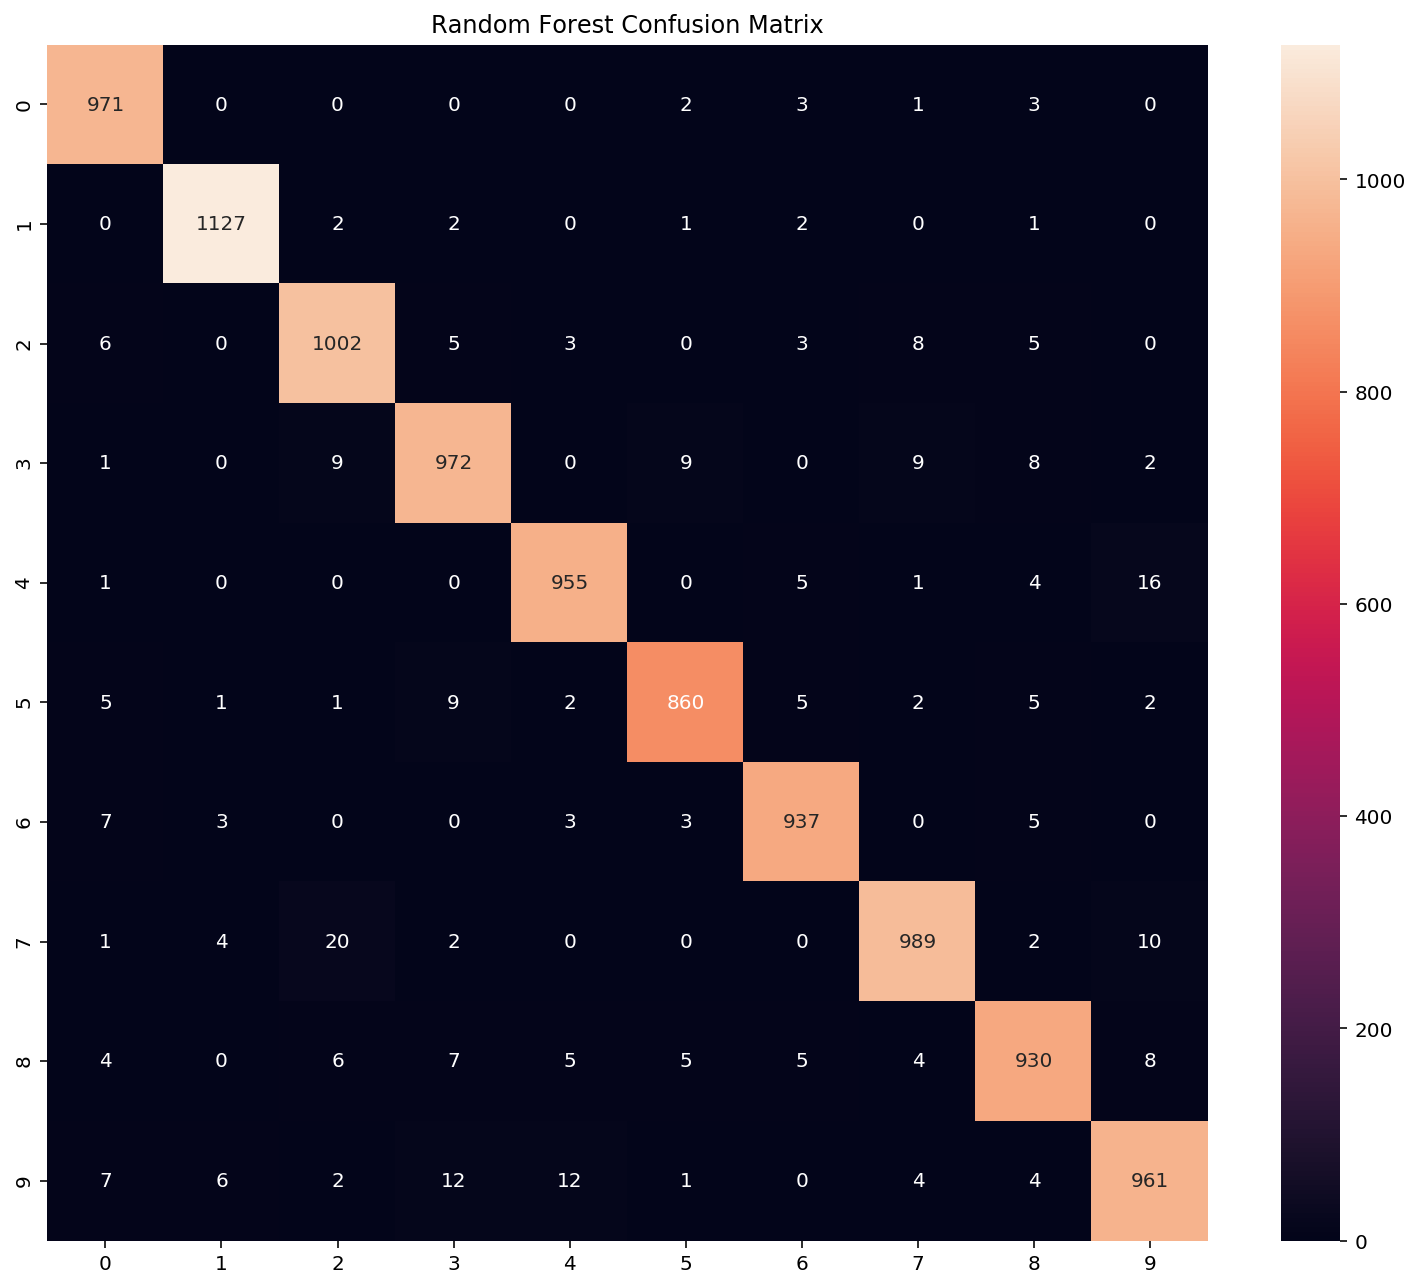

In [82]:
rf_confusion = confusion_matrix(test_y, rf_y_pred)

plt.figure(figsize = (13,11))
heatmap(rf_confusion, annot = True, fmt ='g')
plt.title("Random Forest Confusion Matrix")
plt.show()

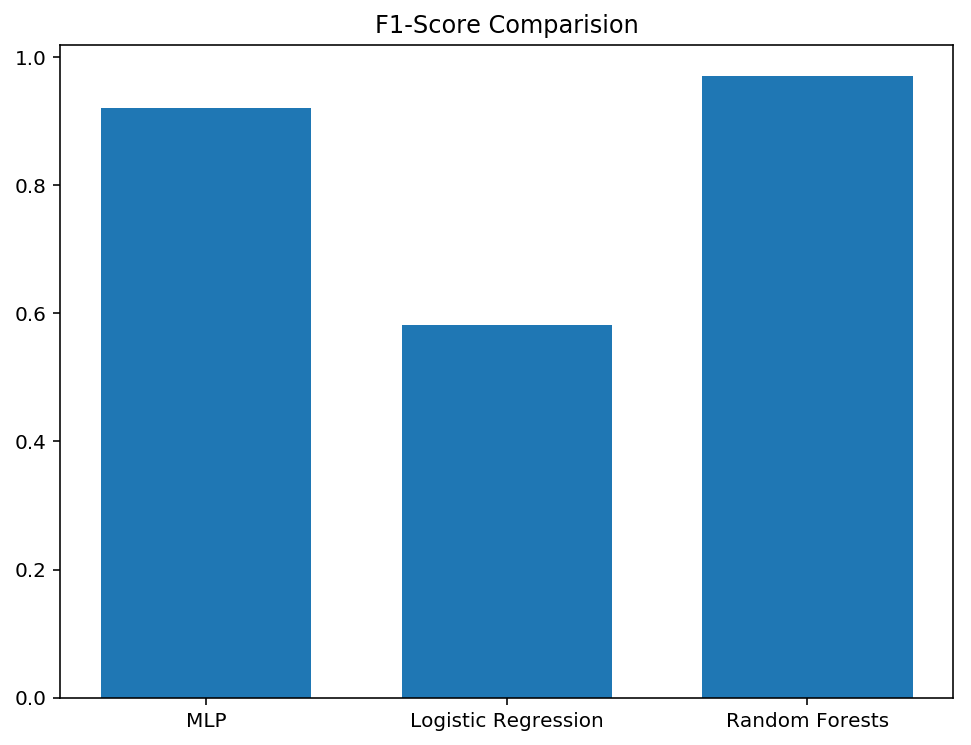

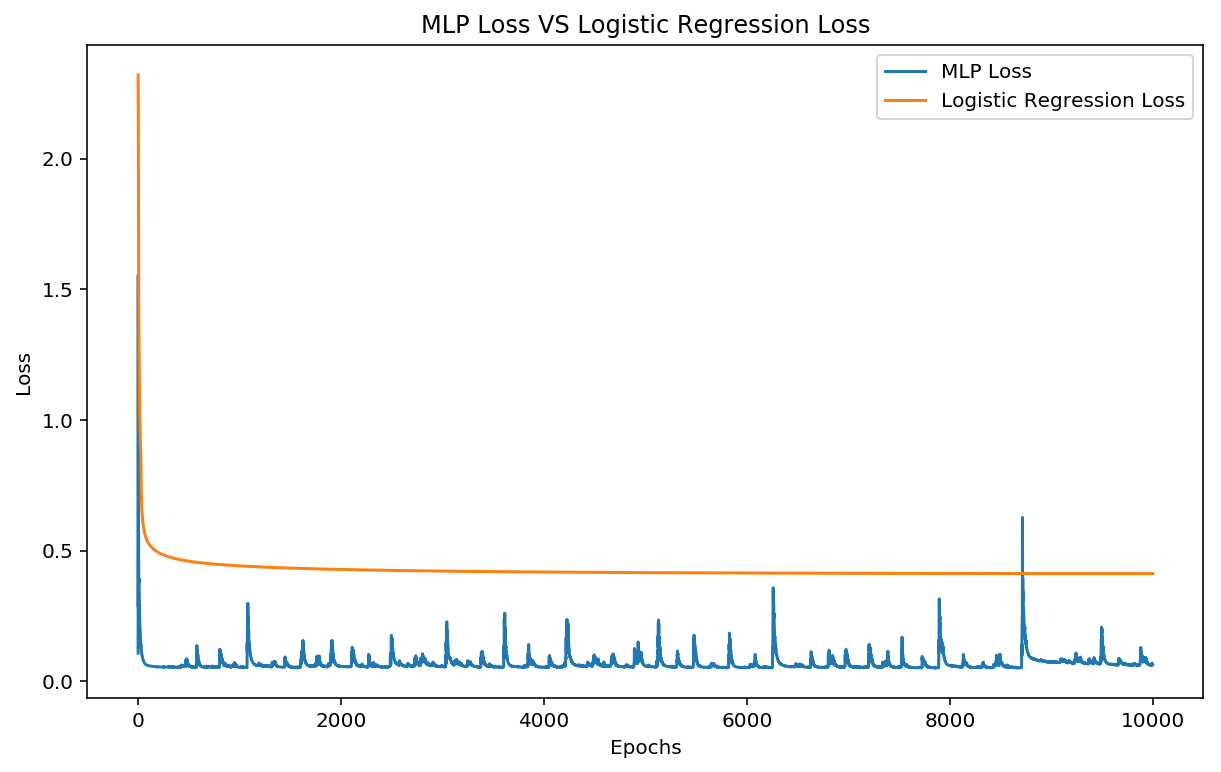

In [117]:
plt.figure(figsize = (8,6))
plt.bar(['MLP', 'Logistic Regression', 'Random Forests'], [mlp_f1_score, logistic_f1_score, rf_f1_score], width = 0.7)
plt.title('F1-Score Comparision')
plt.show()

plt.figure(figsize = (10,6))
plt.plot(mlp_loss, label = "MLP Loss")
plt.plot(logistic_loss, label = "Logistic Regression Loss")
plt.title("MLP Loss VS Logistic Regression Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()